In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None

import numpy as np
import wikipedia
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import confusion_matrix
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.svm import SVC

Let's try to get some model iterations going on, and let's improve that accuracy!

We left off with a decision tree classifier

In [2]:
df = pd.read_csv('../data/WEEK_2_DESCRIPTIONS.csv').drop('Unnamed: 0', axis=1)
df.sample(5)

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating,plots
2551,Frogger's Adventures: The Rescue,PS2,2003.0,Platform,Konami Digital Entertainment,0.16,0.12,0.00,0.04,0.32,59.0,12.0,8.5,6.0,Konami,E,The game contains hop-and-dodge style gameplay...
4630,Age of Empires III: The Asian Dynasties,PC,2007.0,Strategy,Microsoft Game Studios,0.00,0.05,0.00,0.01,0.06,81.0,19.0,8.5,71.0,Big Huge Games,T,The gameplay of Age of Empires III: The Asian ...
3356,Blood Omen 2,XB,2002.0,Action,Eidos Interactive,0.14,0.04,0.00,0.01,0.19,76.0,22.0,9,9.0,Crystal Dynamics,M,Gameplay is presented in 3D and is a combinati...
3125,The Dukes of Hazzard: Return of the General Lee,PS2,2004.0,Racing,Ubisoft,0.11,0.08,0.00,0.03,0.21,52.0,17.0,6.8,8.0,Ratbag,E,The Duke cousins must help Hazzard Countys loc...
1785,Metro 2033,X360,2010.0,Shooter,THQ,0.22,0.23,0.03,0.05,0.54,77.0,83.0,7.9,351.0,4A Games,M,The protagonist of the novel is a 20-year-old ...


In [3]:
def success(value):
    '''
    function for binning the critic scores
    '''
    
    if value > 60:
        if value > 75:
            return 2
        return 1
    return 0

In [4]:
df['success'] = df.Critic_Score.apply(success)

In [5]:
df.success.value_counts()

2    2121
1    2077
0    1301
Name: success, dtype: int64

In [6]:
y = df[['success']]
X = df[['plots']]
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [7]:
tf = TfidfVectorizer(stop_words='english', max_features=1000)
X_train_tf = tf.fit_transform(X_train.plots)
X_test_tf = tf.transform(X_test.plots)

In [8]:
dt = DecisionTreeClassifier()
dt.fit(X_train_tf, y_train)

DecisionTreeClassifier()

In [9]:
print('train acc: ', dt.score(X_train_tf, y_train))
print('test acc: ', dt.score(X_test_tf, y_test))

train acc:  0.9209505334626577
test acc:  0.5963636363636363


Alright so we've got our decision tree classifier, and surprise! we're way overfit

It's not a bad place to start though, almost 60% accuracy with a 3-class classifier

### Model 2

What I'd like to do next is to lemmatize the words before vectorizing. Undoubtedly we're getting some different conjugations and word tenses muddying up our data. We'll modify our clean_text function to lemmatize the words as well

In [10]:
def clean_text(text):
    import string
    wnl = WordNetLemmatizer()
    words = [''.join(ch for ch in s if ch not in string.punctuation) for s in text.split()]
    words = [wnl.lemmatize(word) for word in words]
    return ' '.join(words).lower()

In [11]:
df.plots = df.plots.apply(clean_text)
df.plots[100]

'new addition to the game include an incar driving view one button assisted driving vehicle rollover with detailed undercarriage drifting drag racing and suvs mostly crossovers also new to the series is the addition of stock car albeit generic furthermore the game also provides the ability to paint and upgrade all car whereas forza motorsport 2 only allowed for production and tuner car to be painted or upgraded although one downloadable peugeot lmp could be painted also included is the ability to upgrade certain production and tuner car to the raceclass level represented by the performance rating r3 r2 and r1 whereas forza motorsport 2 did not a well a the ability to create ingame video and upload them to the forza motorsport website forza motorsport 3 is shipped on two disc but only utilizes one for gameplay the second disc serf a the installation disc which contains extra vehicle and track content 19gb in total forza motorsport 3 support only two force feedback racing wheel the micro

Now there's no punctuation, and the words have been slightly lemmatized...? 

**note** I'm not too happy with the lemmatizer, words like 'conquering' 'returning' 'held', I thought it would deal with those

Let's try our decision tree again

In [12]:
y = df[['success']]
X = df[['plots']]
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [13]:
tf = TfidfVectorizer(stop_words='english', max_features=2000)
X_train_tf = tf.fit_transform(X_train.plots)
X_test_tf = tf.transform(X_test.plots)
dt = DecisionTreeClassifier(class_weight='balanced')
dt.fit(X_train_tf, y_train)

DecisionTreeClassifier(class_weight='balanced')

In [14]:
print('train acc: ', dt.score(X_train_tf, y_train))
print('test acc: ', dt.score(X_test_tf, y_test))

train acc:  0.9170708050436469
test acc:  0.5949090909090909


Grabbing that one percent, alright

### Model 3

Let's try a naive bayes classifier...the big guns

In [15]:
nb = MultinomialNB()

In [16]:
nb.fit(X_train_tf, y_train.values.ravel())

MultinomialNB()

In [17]:
print('train acc: ', nb.score(X_train_tf, y_train))
print('test acc: ', nb.score(X_test_tf, y_test))

train acc:  0.6205140640155189
test acc:  0.5294545454545454


So that's worse, I think because the multinomial naive Bayes algorithm is best suited to deal with the integer features of count-vectorized language.

let's just see if that helps

In [18]:
cv = CountVectorizer(max_features=2000)
X_train_cv = cv.fit_transform(X_train.plots)
X_test_cv = cv.transform(X_test.plots)

In [19]:
nb.fit(X_train_cv, y_train.values.ravel())

MultinomialNB()

In [20]:
print('train acc: ', nb.score(X_train_cv, y_train))
print('test acc: ', nb.score(X_test_cv, y_test))

train acc:  0.5482541222114452
test acc:  0.49527272727272725


*It was worth a shot, alright!?*

### Model 4

Now I'd like to try a random forest classifier....the *really* big guns

First we'll just see what the vanilla classifier can do here

In [21]:
tf = TfidfVectorizer(stop_words='english', max_features=3000, ngram_range=(1,2))
X_train_tf = tf.fit_transform(X_train.plots)
X_test_tf = tf.transform(X_test.plots)
rf = RandomForestClassifier(class_weight='balanced')
rf.fit(X_train_tf, y_train.values.ravel())

RandomForestClassifier(class_weight='balanced')

In [22]:
print('train acc: ', rf.score(X_train_tf, y_train))
print('test acc: ', rf.score(X_test_tf, y_test))

train acc:  0.9175557710960233
test acc:  0.645090909090909


Eeking out those percentages once again


In [23]:
svc = SVC()
svc.fit(X_train_tf, y_train.values.ravel())

SVC()

In [24]:
print('train acc: ', rf.score(X_train_tf, y_train))
print('test acc: ', rf.score(X_test_tf, y_test))

train acc:  0.9175557710960233
test acc:  0.645090909090909


### Time to blow it up with a *mean* grid search

In [25]:
params = {'C': [.2, .5, 1],
          'kernel': ['poly', 'linear'],
          'class_weight': ['balanced', None]}
svc = SVC()
gs = GridSearchCV(svc, params)


In [26]:
# gs.fit(X_train_tf, y_train.values.ravel())

In [27]:
# gs.best_params_

In [28]:
# gs.best_estimator_.score(X_test_tf, y_test)

In [29]:
feature_array = np.array(tf.get_feature_names())
tfidf_sorting = np.argsort(X_train_tf.toarray()).flatten()[::-1]

n = 100
top_n = feature_array[tfidf_sorting][:n]

In [30]:
top_n

array(['boat', 'city', 'god', 'entrance', 'gift', 'statue', 'win', 'gold',
       'leave', 'ball', 'map', 'guard', 'native', 'citizen', 'hide',
       'fall', 'losing', 'come', 'pair', 'stay', 'close', 'sacrifice',
       'near', 'men', 'giant', 'real', 'causing', 'world', 'given',
       'like', 'encounter', 'discovers', 'game', 'marker', 'horse',
       'wear', 'player game', 'adding', 'peaceful', 'ritual',
       'conversation', 'break free', 'elder', 'presumably', 'insists',
       'desire', 'crowd', 'preparing', 'escort', 'received', 'spare',
       'jungle', 'construction', 'thought', 'replaced', 'thrown', 'begin',
       'round', 'golden', 'realize', 'chief', 'civilian', 'notice',
       'succeeds', 'caught', 'clear', 'direction', 'needed', 'remain',
       'prepare', 'relationship', 'suggests', 'block', 'knowing',
       'legendary', 'reason', 'surface', 'believing', 'adventure',
       'prisoner', 'rock', 'promise', 'looking', 'telling', 'cut',
       'spirit', 'difficulty', '

In [31]:
tfidf_sorting

array([ 298,  457, 1164, ..., 1982, 1981,    0], dtype=int64)

In [32]:
np.argsort(X_train_tf.toarray())

array([[   0, 1981, 1982, ...,  437,  950, 2743],
       [   0, 1988, 1989, ..., 2678,  489, 1512],
       [   0, 1989, 1990, ..., 2772,  658, 1226],
       ...,
       [   0, 1975, 1976, ...,  146, 2545,  828],
       [   0, 1990, 1991, ...,  373, 2118, 2114],
       [   0, 1971, 1972, ..., 1164,  457,  298]], dtype=int64)

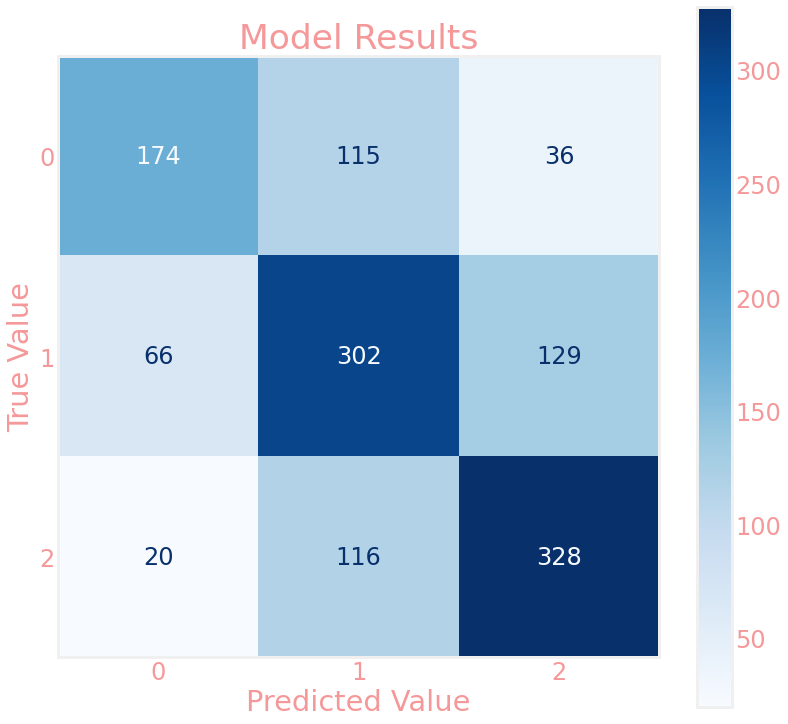

In [33]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 24
plt.rc_context({ 'xtick.color':'#F59899', 'ytick.color':'#F59899', 'figure.facecolor':'white'})
fig, ax = plt.subplots(figsize=(12,12))
plot_confusion_matrix(rf, X_test_tf, y_test, cmap='Blues', ax=ax);
ax.set_ylabel('True Value', color='#F59899')
ax.set_title('Model Results', color='#F59899')

ax.set_xlabel('Predicted Value', color='#F59899')
ax.grid(False)
plt.savefig('../src/figures/confusion.png', transparent=True)

## Exploration Tangent

I would like to explore document normalization. This is the idea that when you have multiple documents in your corpus of varying lengths, it can affect your vectorization by making the vectors of longest documents have a higher magnitude. I think I got that right. 

Let's see how long our documents are

In [34]:
df.plots.apply(lambda x: len(x.split())).describe()

count    5143.000000
mean      419.355240
std       321.381298
min         7.000000
25%       157.000000
50%       348.000000
75%       633.000000
max      3085.000000
Name: plots, dtype: float64

**God dang,** we have one that is 7 words long and one that is over 3000 words long... that could be a problem

In [35]:
X_train_tf[0].sum()

7.422719667810072

In [45]:
from sklearn.preprocessing import normalize
normed = normalize(X_train_tf, norm='l1', axis=1)
normed_test = normalize(X_test_tf, norm='l1', axis=1)

In [46]:
normed[0].sum()

0.9999999999999998

In [47]:
svc = SVC()
svc.fit(normed, y_train.values.ravel())

SVC()

In [48]:
print('train acc: ', svc.score(normed, y_train))
print('test acc: ', svc.score(normed_test, y_test))

train acc:  0.8711433756805808
test acc:  0.6088646967340591


In [25]:
stops = stopwords.words('english')
more_stops = ['game', 'gameplay', 'players', 'win', 'battle']
stops += more_stops

In [26]:
tf = TfidfVectorizer(stop_words=stops, max_features=3000, ngram_range=(1,2))
X_train_tf = tf.fit_transform(X_train.plots)
X_test_tf = tf.transform(X_test.plots)
rf = RandomForestClassifier(class_weight='balanced')
rf.fit(X_train_tf, y_train.values.ravel())

RandomForestClassifier(class_weight='balanced')

In [27]:
print('train acc: ', rf.score(X_train_tf, y_train))
print('test acc: ', rf.score(X_test_tf, y_test))

train acc:  0.9180407371483996
test acc:  0.6538181818181819


### Pipeline

So I realize that I was doing something wrong earlier when I was grid-searching and cross-validating. I was preprocessing the data outside of the cross-validation folds, and I was therefore not getting a good picture of what the scores were.

In [52]:
from sklearn.pipeline import Pipeline

pipe = Pipeline